In [25]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import IPython.display as display

def highlight_chemical_groups(smiles, smarts_patterns):
    # Function to find chemical groups in the molecule
    def find_chemical_groups(smiles, smarts_patterns):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        
        chemical_groups = {}
        for smarts, group_name in smarts_patterns.items():
            pattern = Chem.MolFromSmarts(smarts)
            if pattern is None:
                raise ValueError(f"Invalid SMARTS pattern: {smarts}")
            
            matches = mol.GetSubstructMatches(pattern)
            if matches:
                chemical_groups[group_name] = matches
        
        return chemical_groups

    # Find chemical groups in the molecule
    chemical_groups = find_chemical_groups(smiles, smarts_patterns)

    mol = Chem.MolFromSmiles(smiles)

    highlight_atoms = set()
    highlight_bonds = set()

    # Highlight atoms and bonds corresponding to the identified chemical groups
    for name, matches in chemical_groups.items():
        for match in matches:
            highlight_atoms.update(match)
            for i in range(len(match)):
                for j in range(i+1, len(match)):
                    bond = mol.GetBondBetweenAtoms(match[i], match[j])
                    if bond is not None:
                        highlight_bonds.add(bond.GetIdx())

    # Generate the image with highlighted chemical groups using higher resolution
    drawer = rdMolDraw2D.MolDraw2DCairo(1000, 1000)
    opts = drawer.drawOptions()
    opts.highlightColour = (1, 0, 0)
    highlight_colors = {atom_idx: (0.9, 0.5, 0.5) for atom_idx in highlight_atoms}
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=list(highlight_atoms), highlightBonds=list(highlight_bonds), highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()

    img = drawer.GetDrawingText()

    display.display(display.Image(data=img, format='png'))

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.molSize = 1000,1000

In [17]:
from rdkit import Chem
from collections import defaultdict

#finding chemical functional groups and their Derivatives analyzed from smarts

def find_smiles_patterns(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES string. Unable to parse molecule."

    # Define a list to store the chemical groups found in the SMILES
    chemical_groups = []

# SMARTS patterns to recognize chemical groups, better than smiles for multiple compnent groups like carboxylic acid, imide etc....
    smarts_patterns = {
    '[C]=[C]': 'Alkene',
    '[CX2]#[CX2]': 'Alkyne',
    '[CX3]=[CX2]=[CX3]': 'Allene',
    '[ClX1][CX4]': 'Alkylchloride',
    '[FX1][CX4]': 'Alkylfluoride',
    '[BrX1][CX4]': 'Alkylbromide',
    '[IX1][CX4]': 'Alkyliodide',
    '[OX2H][CX4H2;!$(C([OX2H])[O,S,#7,#15])]': 'Primary_alcohol',
    '[OX2H][CX4H;!$(C([OX2H])[O,S,#7,#15])]': 'Secondary_alcohol',
    '[OX2H][CX4D4;!$(C([OX2H])[O,S,#7,#15])]': 'Tertiary_alcohol',
    '[OX2]([CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])])[CX4;!$(C([OX2])[O,S,#7,#15])]': 'Dialkylether',
    '[SX2]([CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])])[CX4;!$(C([OX2])[O,S,#7,#15])]': 'Dialkylthioether',
    '[OX2](c)[CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])]': 'Alkylarylether',
    '[c][OX2][c]': 'Diarylether',
    '[SX2](c)[CX4;!$(C([OX2])[O,S,#7,#15,F,Cl,Br,I])]': 'Alkylarylthioether',
    '[c][SX2][c]': 'Diarylthioether',
    '[O+;!$([O]~[!#6]);!$([S]*~[#7,#8,#15,#16])]': 'Oxonium',
    '[NX3H2+0,NX4H3+;!$([N][!C]);!$([N]*~[#7,#8,#15,#16])]': 'Primary_aliph_amine',
    '[NX3H1+0,NX4H2+;!$([N][!C]);!$([N]*~[#7,#8,#15,#16])]': 'Secondary_aliph_amine',
    '[NX3H0+0,NX4H1+;!$([N][!C]);!$([N]*~[#7,#8,#15,#16])]': 'Tertiary_aliph_amine',
    '[NX4H0+;!$([N][!C]);!$([N]*~[#7,#8,#15,#16])]': 'Quaternary_aliph_ammonium',
    '[NX3H2+0,NX4H3+]c': 'Primary_arom_amine',
    '[NX3H1+0,NX4H2+;!$([N][!c]);!$([N]*~[#7,#8,#15,#16])]': 'Secondary_arom_amine',
    '[NX3H0+0,NX4H1+;!$([N][!c]);!$([N]*~[#7,#8,#15,#16])]': 'Tertiary_arom_amine',
    '[NX4H0+;!$([N][!c]);!$([N]*~[#7,#8,#15,#16])]': 'Quaternary_arom_ammonium',
    '[NX3H1+0,NX4H2+;$([N]([c])[C]);!$([N]*~[#7,#8,#15,#16])]': 'Secondary_mixed_amine',
    '[NX3H0+0,NX4H1+;$([N]([c])([C])[#6]);!$([N]*~[#7,#8,#15,#16])]': 'Tertiary_mixed_amine',
    '[NX4H0+;$([N]([c])([C])[#6][#6]);!$([N]*~[#7,#8,#15,#16])]': 'Quaternary_mixed_ammonium',
    '[N+;!$([N]~[!#6]);!$(N=*);!$([N]*~[#7,#8,#15,#16])]': 'Ammonium',
    '[SX2H][CX4;!$(C([SX2H])~[O,S,#7,#15])]': 'Alkylthiol',
    '[SX2]([CX4;!$(C([SX2])[O,S,#7,#15,F,Cl,Br,I])])[CX4;!$(C([SX2])[O,S,#7,#15])]': 'Dialkylthioether',
    '[SX2](c)[CX4;!$(C([SX2])[O,S,#7,#15])]': 'Alkylarylthioether',
    '[SX2D2][SX2D2]': 'Disulfide',
    '[OX2H][OX2]': 'Hydroperoxide',
    '[OX2D2][OX2D2]': 'Peroxo',
    '[LiX1][#6,#14]': 'Organolithium_compounds',
    '[MgX2][#6,#14]': 'Organomagnesium_compounds',
    '[!#1;!#5;!#6;!#7;!#8;!#9;!#14;!#15;!#16;!#17;!#33;!#34;!#35;!#52;!#53;!#85]~[#6;!-]': 'Organometallic_compounds',
    '[$([CX3H][#6]),$([CX3H2])]=[OX1]': 'Aldehyde',
    '[#6]([#6])(=O)[#6]': 'Ketone',
    'C=C=O': 'Ketene',
    '[$([CX3H][#6]),$([CX3H2])]=[SX1]': 'Thioaldehyde',
    '[#6][CX3](=[SX1])[#6]': 'Thioketone',
    'C=C=S': 'Thioketene',
    '[NX2;$([N][#6]),$([NH]);!$([N][CX3]=[#7,#8,#15,#16])]=[CX3;$([CH2]),$([CH][#6]),$([C]([#6])[#6])]': 'Imine',
    '[NX3+;!$([N][!#6]);!$([N][CX3]=[#7,#8,#15,#16])]': 'Immonium',
    '[NX2](=[CX3;$([CH2]),$([CH][#6]),$([C]([#6])[#6])])[OX2H]': 'Oxime',
    '[NX2](=[CX3;$([CH2]),$([CH][#6]),$([C]([#6])[#6])])[OX2][#6;!$(C=[#7,#8])]' : 'Oximether',
    '[OX2]([#6;!$(C=[O,S,N])])[CX4;!$(C(O)(O)[!#6])][OX2][#6;!$(C=[O,S,N])]': 'Acetal',
    '[OX2H][CX4;!$(C(O)(O)[!#6])][OX2][#6;!$(C=[O,S,N])]': 'Hemiacetal',
    '[NX3v3;!$(NC=[#7,#8,#15,#16])]([#6])[CX4;!$(C(N)(N)[!#6])][NX3v3;!$(NC=[#7,#8,#15,#16])][#6]': 'Aminal',
    '[NX3v3;!$(NC=[#7,#8,#15,#16])]([#6])[CX4;!$(C(N)(N)[!#6])][OX2H]': 'Hemiaminal',
    '[SX2]([#6;!$(C=[O,S,N])])[CX4;!$(C(S)(S)[!#6])][SX2][#6;!$(C=[O,S,N])]': 'Thioacetal',
    '[SX2]([#6;!$(C=[O,S,N])])[CX4;!$(C(S)(S)[!#6])][OX2H]': 'Thiohemiacetal',
    '[NX3v3,SX2,OX2;!$(*C=[#7,#8,#15,#16])][CX4;!$(C([N,S,O])([N,S,O])[!#6])][FX1,ClX1,BrX1,IX1]': 'Halogen_acetal_like',
    '[NX3v3,SX2,OX2;!$(*C=[#7,#8,#15,#16])][CX4;!$(C([N,S,O])([N,S,O])[!#6])][FX1,ClX1,BrX1,IX1,NX3v3,SX2,OX2;!$(*C=[#7,#8,#15,#16])]': 'Acetal_like',
    '[NX3v3,SX2,OX2;$(**=[#7,#8,#15,#16])][CX4;!$(C([N,S,O])([N,S,O])[!#6])][FX1,ClX1,BrX1,IX1]': 'Halogenmethylen_ester_and_similar',
    '[NX3v3,SX2,OX2;$(**=[#7,#8,#15,#16])][CX4;!$(C([N,S,O])([N,S,O])[!#6])][NX3v3,SX2,OX2;!$(*C=[#7,#8,#15,#16])]': 'NOS_methylen_ester_and_similar',
    '[NX3v3,SX2,OX2;$(**=[#7,#8,#15,#16])][CX4;!$(C([N,S,O])([N,S,O])[!#6])][FX1,ClX1,BrX1,IX1,NX3v3,SX2,OX2;!$(*C=[#7,#8,#15,#16])]': 'Hetero_methylen_ester_and_similar',
    '[NX1]#[CX2][CX4;$([CH2]),$([CH]([CX2])[#6]),$(C([CX2])([#6])[#6])][OX2H]': 'Cyanhydrine',
    '[ClX1][CX3]=[CX3]': 'Chloroalkene',
    '[FX1][CX3]=[CX3]': 'Fluoroalkene',
    '[BrX1][CX3]=[CX3]': 'Bromoalkene',
    '[IX1][CX3]=[CX3]': 'Iodoalkene',
    '[OX2H][CX3;$([H1]),$(C[#6])]=[CX3]': 'Enol',
    '[OX2H][CX3;$([H1]),$(C[#6])]=[CX3;$([H1]),$(C[#6])][OX2H]': 'Endiol',
    '[OX2]([#6;!$(C=[N,O,S])])[CX3;$([H0][#6]),$([H1])]=[CX3]': 'Enolether',
    '[OX2]([CX3]=[OX1])[#6X3;$([#6][#6]),$([H1])]=[#6X3;!$(C[OX2H])]': 'Enolester',
    '[NX3;$([NH2][CX3]),$([NH1]([CX3])[#6]),$([N]([CX3])([#6])[#6]);!$([N]*=[#7,#8,#15,#16])][CX3;$([CH]),$([C][#6])]=[CX3]': 'Enamine',
    '[SX2H][CX3;$([H1]),$(C[#6])]=[CX3]': 'Thioenol',
    '[SX2]([#6;!$(C=[N,O,S])])[CX3;$(C[#6]),$([CH])]=[CX3]': 'Thioenolether',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[ClX1]': 'Acylchloride',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[FX1]': 'Acylfluoride',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[BrX1]': 'Acylbromide',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[IX1]': 'Acyliodide',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[FX1,ClX1,BrX1,IX1]': 'Acylhalide',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[$([OX2H]),$([OX1-])]': 'Carboxylic_acid',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[OX2][#6;!$(C=[O,N,S])]': 'Carboxylic_ester',
    '[#6][#6X3R](=[OX1])[#8X2][#6;!$(C=[O,N,S])]': 'Lactone',
    '[CX3;$([H0][#6]),$([H1])](=[OX1])[#8X2][CX3;$([H0][#6]),$([H1])](=[OX1])': 'Carboxylic_anhydride',
    '[CX3;!R;$([C][#6]),$([CH]);$([C](=[OX1])[$([SX2H]),$([SX1-])]),$([C](=[SX1])[$([OX2H]),$([OX1-])])]': 'Carbothioic_acid',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[SX2][#6;!$(C=[O,N,S])]': 'Carbothioic_S_ester',
    '[#6][#6X3R](=[OX1])[#16X2][#6;!$(C=[O,N,S])]': 'Carbothioic_S_lactone',
    '[CX3;$([H0][#6]),$([H1])](=[SX1])[OX2][#6;!$(C=[O,N,S])]': 'Carbothioic_O_ester',
    '[#6][#6X3R](=[SX1])[#8X2][#6;!$(C=[O,N,S])]': 'Carbothioic_O_lactone',
    '[CX3;$([H0][#6]),$([H1])](=[SX1])[FX1,ClX1,BrX1,IX1]': 'Carbothioic_halide',
    '[CX3;!R;$([C][#6]),$([CH]);$([C](=[SX1])[SX2H])]': 'Carbodithioic_acid',
    '[CX3;!R;$([C][#6]),$([CH]);$([C](=[SX1])[SX2][#6;!$(C=[O,N,S])])]': 'Carbodithioic_ester',
    '[#6][#6X3R](=[SX1])[#16X2][#6;!$(C=[O,N,S])]': 'Carbodithiolactone',
    '[CX3](=[OX1])[NX3H1][CX3](=[OX1])[OX2H1]': 'Amide',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[NX3H2]': 'Primary_amide',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[#7X3H1][#6;!$(C=[O,N,S])]': 'Secondary_amide',
    '[CX3;$([R0][#6]),$([H1R0])](=[OX1])[#7X3H0]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])]': 'Tertiary_amide',
    'c1cccnc1': 'Pyridine_Derivatives',
    'c1cnccn1': 'Pyrazine_derivatives',
    '[#6R][#6X3R](=[OX1])[#7X3;$([H1][#6;!$(C=[O,N,S])]),$([H0]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Lactam',
    '[#6X3;$([H0][#6]),$([H1])](=[OX1])[#7X3H0]([#6])[#6X3;$([H0][#6]),$([H1])](=[OX1])': 'Alkyl_imide',
    '[#6X3;$([H0][#6]),$([H1])](=[OX1])[#7X3H0]([!#6])[#6X3;$([H0][#6]),$([H1])](=[OX1])': 'N_hetero_imide',
    '[#6X3;$([H0][#6]),$([H1])](=[OX1])[#7X3H1][#6X3;$([H0][#6]),$([H1])](=[OX1])': 'Imide_acidic',
    '[$([CX3;!R][#6]),$([CX3H;!R])](=[SX1])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Thioamide',
    '[#6R][#6X3R](=[SX1])[#7X3;$([H1][#6;!$(C=[O,N,S])]),$([H0]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Thiolactam',
    '[#6X3;$([H0][#6]),$([H1])](=[OX1])[#8X2][#7X2]=,:[#6X3;$([H0]([#6])[#6]),$([H1][#6]),$([H2])]': 'Oximester',
    '[NX3;!$(NC=[O,S])][CX3R0;$([H1]),$([H0][#6])]=[NX2;!$(NC=[O,S])]': 'Amidine',
    '[CX3;$([H0][#6]),$([H1])](=[OX1])[#7X3;$([H1]),$([H0][#6;!$(C=[O,N,S])])][$([OX2H]),$([OX1-])]': 'Hydroxamic_acid',
    '[CX3;$([H0][#6]),$([H1])](=[OX1])[#7X3;$([H1]),$([H0][#6;!$(C=[O,N,S])])][OX2][#6;!$(C=[O,N,S])]': 'Hydroxamic_acid_ester',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[$([OX2H]),$([OX1-])]': 'Imidoacid',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[$([OX2H]),$([OX1-])]': 'Imidoacid_cyclic',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[OX2][#6;!$(C=[O,N,S])]': 'Imidoester',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[OX2][#6;!$(C=[O,N,S])]': 'Imidolactone',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[$([SX2H]),$([SX1-])]': 'Imidothioacid',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[$([OX2H]),$([OX1-])]': 'Imidoacid_cyclic',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[OX2][#6;!$(C=[O,N,S])]': 'Imidoester',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[OX2][#6;!$(C=[O,N,S])]': 'Imidolactone',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[$([SX2H]),$([SX1-])]': 'Imidothioacid',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[$([SX2H]),$([SX1-])]': 'Imidothioacid_cyclic',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[SX2][#6;!$(C=[O,N,S])]': 'Imidothioester',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[SX2][#6;!$(C=[O,N,S])]': 'Imidothiolactone',
    '[$([$([#6X3][#6]),$([#6X3H])](=[#7X2v3])[#7X3v3][#7X3v3]),$([$([#6X3][#6]),$([#6X3H])]([#7X3v3])=[#7X2v3][#7X3v3])]': 'Amidrazone',
    '[$([#7X3v3;!$(N([#6X3]=[#7X2])C=[O,S])][CX3R0;$([H1]),$([H0][#6])]=[NX2v3;!$(N(=[#6X3][#7X3])C=[O,S])]),$([#7X3v3;!$(N([#6X3]=[#7X2])C=[O,S])][$([CX3R0;$([H1]),$([H0][#6])]=[NX2v3;!$(N(=[#6X3][#7X3])C=[O,S])])])]': 'Amidine',
    '[#6][#6X3R;$([H0](=[NX2;!$(N(=[#6X3][#7X3])C=[O,S])])[#7X3;!$(N([#6X3]=[#7X2])C=[O,S])]),$([H0](-[NX3;!$(N([#6X3]=[#7X2])C=[O,S])])=,:[#7X2;!$(N(=[#6X3][#7X3])C=[O,S])])]': 'Imidolactam',
    '[CX3R0;$([H0][#6]),$([H1])](=[NX2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[FX1,ClX1,BrX1,IX1]': 'Imidoylhalide',
    '[#6R][#6X3R](=,:[#7X2;$([H1]),$([H0][#6;!$(C=[O,N,S])])])[FX1,ClX1,BrX1,IX1]': 'Imidoylhalide_cyclic',
    '[NX3,NX4+;!$([N]~[!#6]);!$([N]*~[#7,#8,#15,#16])][C][CX3](=[OX1])[OX2H,OX1-]': 'Alpha_aminoacid',
    '[OX2H][C][CX3](=[OX1])[OX2H,OX1-]': 'Alpha_hydroxyacid',
    '[NX3;$([N][CX3](=[OX1])[C][NX3,NX4+])][C][CX3](=[OX1])[NX3;$([N][C][CX3](=[OX1])[NX3,OX2,OX1-])]': 'Peptide_middle',
    '[NX3;$([N][CX3](=[OX1])[C][NX3,NX4+])][C][CX3](=[OX1])[OX2H,OX1-]': 'Peptide_C_term',
    '[NX3,NX4+;!$([N]~[!#6]);!$([N]*~[#7,#8,#15,#16])][C][CX3](=[OX1])[NX3;$([N][C][CX3](=[OX1])[NX3,OX2,OX1-])]': 'Peptide_N_term',
    '[#6][OX2][CX4;$(C[#6]),$([CH])]([OX2][#6])[OX2][#6]': 'Carboxylic_orthoester',
    '[CX3]=[CX2]=[OX1]': 'Ketene',
    '[#7X2,#8X3,#16X2;$(*[#6,#14])][#6X3]([#7X2,#8X3,#16X2;$(*[#6,#14])])=[#6X3]': 'Ketenacetal',
    '[NX1]#[CX2]': 'Nitrile',
    '[CX1-]#[NX2+]': 'Isonitrile',
    '[#6;!$(C=[O,N,S])][#8X2][#6X3](=[OX1])[#8X2][#6;!$(C=[O,N,S])]': 'Carbonic_acid_dieester',
    '[#6;!$(C=[O,N,S])][OX2;!R][CX3](=[OX1])[OX2][FX1,ClX1,BrX1,IX1]': 'Carbonic_acid_esterhalide',
    '[#6;!$(C=[O,N,S])][OX2;!R][CX3](=[OX1])[$([OX2H]),$([OX1-])]': 'Carbonic_acid_monoester',
    '[#6;!$(C=[O,N,S])][#8X2][#6X3](=[SX1])[#8X2][#6;!$(C=[O,N,S])]': 'Thiocarbonic_acid_dieester',
    '[#6;!$(C=[O,N,S])][OX2;!R][CX3](=[SX1])[OX2][FX1,ClX1,BrX1,IX1]': 'Thiocarbonic_acid_esterhalide',
    '[#6;!$(C=[O,N,S])][OX2;!R][CX3](=[SX1])[$([OX2H]),$([OX1-])]': 'Thiocarbonic_acid_monoester',
    '[#7X3;!$([#7][!#6])][#6X3](=[OX1])[#7X3;!$([#7][!#6])]': 'Urea',
    '[#7X3;!$([#7][!#6])][#6X3](=[SX1])[#7X3;!$([#7][!#6])]': 'Thiourea',
    '[#7X2;!$([#7][!#6])]=,:[#6X3]([#8X2&!$([#8][!#6]),OX1-])[#7X3;!$([#7][!#6])]': 'Isourea',
    '[#7X2;!$([#7][!#6])]=,:[#6X3]([#16X2&!$([#16][!#6]),SX1-])[#7X3;!$([#7][!#6])]': 'Isothiourea',
    '[N;v3X3,v4X4+][CX3](=[N;v3X2,v4X3+])[N;v3X3,v4X4+]': 'Guanidine_Derivative',
    '[NX3]C(=[OX1])[O;X2H,X1-]': 'Carbaminic_acid',
    '[#7X3][#6](=[OX1])[#8X2][#6]': 'Urethan',
    '[#7X3][#6](=[OX1])[#7X3][#6](=[OX1])[#7X3]': 'Biuret',
    '[#7X3][#7X3][#6X3]([#7X3;!$([#7][#7])])=[OX1]': 'Semicarbazide',
    '[#7X3][#7X3][#6X3]([#7X3][#7X3])=[OX1]': 'Carbazide',
    '[#7X2](=[#6])[#7X3][#6X3]([#7X3;!$([#7][#7])])=[OX1]': 'Semicarbazone',
    '[#7X2](=[#6])[#7X3][#6X3]([#7X3][#7X3])=[OX1]': 'Carbazone',
    '[#7X3][#7X3][#6X3]([#7X3;!$([#7][#7])])=[SX1]': 'Thiosemicarbazide',
    '[#7X3][#7X3][#6X3]([#7X3][#7X3])=[SX1]': 'Thiocarbazide',
    '[#7X2](=[#6])[#7X3][#6X3]([#7X3;!$([#7][#7])])=[SX1]': 'Thiosemicarbazone',
    '[#7X2](=[#6])[#7X3][#6X3]([#7X3][#7X3])=[SX1]': 'Thiocarbazone',
    '[NX2]=[CX2]=[OX1]': 'Isocyanate',
    '[OX2][CX2]#[NX1]': 'Cyanate',
    '[NX2]=[CX2]=[SX1]': 'Isothiocyanate',
    '[SX2][CX2]#[NX1]': 'Thiocyanate',
    '[NX2]=[CX2]=[NX2]': 'Carbodiimide',
    '[CX4H0]([O,S,#7])([O,S,#7])([O,S,#7])[O,S,#7,F,Cl,Br,I]': 'Orthocarbonic_derivatives',
    '[OX2H][c]': 'Phenol',
    '[OX2H][c][c][OX2H]': '1,2-Diphenol',
    '[Cl][c]': 'Arylchloride',
    '[F][c]': 'Arylfluoride',
    '[Br][c]': 'Arylbromide',
    '[I][c]': 'Aryliodide',
    '[SX2H][c]': 'Arylthiol',
    '[c]=[NX2;$([H1]),$([H0][#6;!$([C]=[N,S,O])])]': 'Iminoarene',
    '[c]=[OX1]': 'Oxoarene',
    '[c]=[SX1]': 'Thioarene',
    '[nX3H1+0]': 'Hetero_N_basic_H',
    '[nX3H0+0]': 'Hetero_N_basic_no_H',
    '[nX2,nX3+]': 'Hetero_N_nonbasic',
    '[o]': 'Hetero_O',
    '[sX2]': 'Hetero_S',
    '[a;!c]': 'Heteroaromatic',
    '[!#6;!R0]': 'Heterocylcic',
    '[NX2](=[OX1])[O;$([X2]),$([X1-])]': 'Nitrite',
    '[SX2][NX2]=[OX1]': 'Thionitrite',
    '[$([NX3](=[OX1])(=[OX1])[O;$([X2]),$([X1-])]),$([NX3+]([OX1-])(=[OX1])[O;$([X2]),$([X1-])])]': 'Nitrate',
    '[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]': 'Nitro',
    '[NX2](=[OX1])[!#7;!#8]': 'Nitroso',
    '[NX1]~[NX2]~[NX2,NX1]': 'Azide',
    '[CX3](=[OX1])[NX2]~[NX2]~[NX1]': 'Acylazide',
    '[$([#6]=[NX2+]=[NX1-]),$([#6-]-[NX2+]#[NX1])]': 'Diazo',
    '[#6][NX2+]#[NX1]': 'Diazonium',
    '[#7;!$(N*=O)][NX2]=[OX1]': 'Nitrosamine',
    '[NX2](=[OX1])N-*=O': 'Nitrosamide',
    '[$([#7+][OX1-]),$([#7v5]=[OX1]);!$([#7](~[O])~[O]);!$([#7]=[#7])]': 'N-Oxide',
    '[NX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6]);!$(NC=[O,N,S])][NX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6]);!$(NC=[O,N,S])]': 'Hydrazine',
    '[NX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6]);!$(NC=[O,N,S])][NX2]=[#6]': 'Hydrazone',
    '[NX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6]);!$(NC=[O,N,S])][OX2;$([H1]),$(O[#6;!$(C=[N,O,S])])]': 'Hydroxylamine',
    '[SX2][NX2]=[OX1]': 'Thionitrite',
    '[SX4](=[OX1])(=[OX1])([$([OX2H]),$([OX1-])])[$([OX2H]),$([OX1-])]': 'Sulfuric_acid',
    '[SX4](=[OX1])(=[OX1])([$([OX2H]),$([OX1-])])[OX2][#6;!$(C=[O,N,S])]': 'Sulfuric_monoester',
    '[SX4](=[OX1])(=[OX1])([OX2][#6;!$(C=[O,N,S])])[OX2][#6;!$(C=[O,N,S])]': 'Sulfuric_diester',
    '[SX4](=[OX1])(=[OX1])([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])[$([OX2H]),$([OX1-])]': 'Sulfuric_monoamide',
    '[SX4](=[OX1])(=[OX1])([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Sulfuric_diamide',
    '[SX4](=[OX1])(=[OX1])([#7X3][#6;!$(C=[O,N,S])])[OX2][#6;!$(C=[O,N,S])]': 'Sulfuric_esteramide',
    '[SX4D4](=[!#6])(=[!#6])([!#6])[!#6]': 'Sulfuric_derivative',
    '[SX4;$([H1]),$([H0][#6])](=[OX1])(=[OX1])[$([OX2H]),$([OX1-])]': 'Sulfonic_acid',
    '[SX4;$([H1]),$([H0][#6])](=[OX1])(=[OX1])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Sulfonamide',
    '[SX4;$([H1]),$([H0][#6])](=[OX1])(=[OX1])[OX2][#6;!$(C=[O,N,S])]': 'Sulfonic_ester',
    '[SX4;$([H1]),$([H0][#6])](=[OX1])(=[OX1])[FX1,ClX1,BrX1,IX1]': 'Sulfonic_halide',
    '[SX4;$([H1]),$([H0][#6])](=[!#6])(=[!#6])[!#6]': 'Sulfonic_derivative',
    '[SX3;$([H1]),$([H0][#6])](=[OX1])[$([OX2H]),$([OX1-])]': 'Sulfinic_acid',
    '[SX3;$([H1]),$([H0][#6])](=[OX1])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Sulfinic_amide',
    '[SX3;$([H1]),$([H0][#6])](=[OX1])[OX2][#6;!$(C=[O,N,S])]': 'Sulfinic_ester',
    '[SX3;$([H1]),$([H0][#6])](=[OX1])[FX1,ClX1,BrX1,IX1]': 'Sulfinic_halide',
    '[SX3;$([H1]),$([H0][#6])](=[!#6])[!#6]': 'Sulfinic_derivative',
    '[SX2;$([H1]),$([H0][#6])][$([OX2H]),$([OX1-])]': 'Sulfenic_acid',
    '[SX2;$([H1]),$([H0][#6])][#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]': 'Sulfenic_amide',
    '[SX2;$([H1]),$([H0][#6])][OX2][#6;!$(C=[O,N,S])]': 'Sulfenic_ester',
    '[SX2;$([H1]),$([H0][#6])][FX1,ClX1,BrX1,IX1]': 'Sulfenic_halide',
    '[SX2;$([H1]),$([H0][#6])][!#6]': 'Sulfenic_derivative',
    '[PX4D4](=[OX1])([$([OX2H]),$([OX1-])])([$([OX2H]),$([OX1-])])[$([OX2H]),$([OX1-])]': 'Phosphoric_acid',
    '[PX4D4](=[OX1])([$([OX2H]),$([OX1-])])([$([OX2H]),$([OX1-])])[OX2][#6;!$(C=[O,N,S])]' : 'Phosphoric_monoester',
    '[PX4D4](=[OX1])([$([OX2H]),$([OX1-])])([OX2][#6;!$(C=[O,N,S])])[OX2][#6;!$(C=[O,N,S])]' : 'Phosphoric_diester',
    '[PX4D4](=[OX1])([OX2][#6;!$(C=[O,N,S])])([OX2][#6;!$(C=[O,N,S])])[OX2][#6;!$(C=[O,N,S])]' : 'Phosphoric_triester',
    '[PX4D4](=[OX1])([$([OX2H]),$([OX1-])])([$([OX2H]),$([OX1-])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphoric_monoamide',
    '[PX4D4](=[OX1])([$([OX2H]),$([OX1-])])([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphoric_diamide',
    '[PX4D4](=[OX1])([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphoric_triamide',
    '[PX4D4](=[OX1])([$([OX2H]),$([OX1-])])([OX2][#6;!$(C=[O,N,S])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphoric_monoestermonoamide',
    '[PX4D4](=[OX1])([OX2][#6;!$(C=[O,N,S])])([OX2][#6;!$(C=[O,N,S])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphoric_diestermonoamide',
    '[PX4D4](=[OX1])([OX2][#6;!$(C=[O,N,S])])([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphoric_monoesterdiamide',
    '[PX4D4](=[!#6])([!#6])([!#6])[!#6]' : 'Phosphoric_acid_derivative',
    '[PX4;$([H2]),$([H1][#6]),$([H0]([#6])[#6])](=[OX1])[$([OX2H]),$([OX1-])]': 'Phosphinic_acid',
    '[PX4;$([H2]),$([H1][#6]),$([H0]([#6])[#6])](=[OX1])[OX2][#6;!$(C=[O,N,S])]' : 'Phosphinic_ester',
    '[PX4;$([H2]),$([H1][#6]),$([H0]([#6])[#6])](=[OX1])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphinic_amide',
    '[PX4;$([H2]),$([H1][#6]),$([H0]([#6])[#6])](=[!#6])[!#6]' : 'Phosphinic_acid_derivative',
    '[PX3;$([H1]),$([H0][#6])]([$([OX2H]),$([OX1-])])[$([OX2H]),$([OX1-])]' : 'Phosphonous_acid',
    '[PX3;$([H1]),$([H0][#6])]([$([OX2H]),$([OX1-])])[OX2][#6;!$(C=[O,N,S])]' : 'Phosphonous_monoester',
    '[PX3;$([H1]),$([H0][#6])]([OX2][#6;!$(C=[O,N,S])])[OX2][#6;!$(C=[O,N,S])]' : 'Phosphonous_diester',
    '[PX3;$([H1]),$([H0][#6])]([$([OX2H]),$([OX1-])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphonous_monoamide',
    '[PX3;$([H1]),$([H0][#6])]([#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphonous_diamide',
    '[PX3;$([H1]),$([H0][#6])]([OX2][#6;!$(C=[O,N,S])])[#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphonous_esteramide',
    '[PX3;$([D2]),$([D3][#6])]([!#6])[!#6]' : 'Phosphonous_derivatives',
    '[PX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6])][$([OX2H]),$([OX1-])]' : 'Phosphinous_acid',
    '[PX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6])][OX2][#6;!$(C=[O,N,S])]' : 'Phosphinous_ester',
    '[PX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6])][#7X3;$([H2]),$([H1][#6;!$(C=[O,N,S])]),$([#7]([#6;!$(C=[O,N,S])])[#6;!$(C=[O,N,S])])]' : 'Phosphinous_amide',
    '[PX3;$([H2]),$([H1][#6]),$([H0]([#6])[#6])][!#6]' : 'Phosphinous_derivatives',
    '[SiX4]([#6])([#6])([#6])[#6]': 'Quart_silane',
    '[SiX4;$([H1]([#6])([#6])[#6]),$([H2]([#6])[#6]),$([H3][#6]),$([H4])]': 'Non-quart_silane',
    '[SiX4]([FX1,ClX1,BrX1,IX1])([#6])([#6])[#6]': 'Silylmonohalide',
    '[SiX4]([!#6])([#6])([#6])[#6]': 'Het_trialkylsilane',
    '[SiX4]([!#6])([!#6])([#6])[#6]': 'Dihet_dialkylsilane',
    '[SiX4]([!#6])([!#6])([!#6])[#6]': 'Trihet_alkylsilane',
    '[SiX4]([!#6])([!#6])([!#6])[!#6]': 'Silicic_acid_derivative',
    '[BX3]([#6])([#6])[#6]': 'Trialkylborane',
    '[BX3]([!#6])([!#6])[!#6]': 'Boric_acid_derivatives',
    '[BX3]([!#6])([!#6])[!#6]': 'Boronic_acid_derivative',
    '[BH1,BH2,BH3,BH4]': 'Borohydride',
    '[BX4]': 'Quaternary_boron',
    '[!#6;!R0]': 'Heterocyclic',
    '[OX2r3]1[#6r3][#6r3]1': 'Epoxide',
    '[NX3H1r3]1[#6r3][#6r3]1': 'NH_aziridine',
    '[D4R;$(*(@*)(@*)(@*)@*)]': 'Spiro',
    '[R;$(*(@*)(@*)@*);!$([D4R;$(*(@*)(@*)(@*)@*)]);!$([R;$(*(@*)(@*)@*);!$([R2;$(*(@*)(@*)(@*)@*)])]@[R;$(*(@*)(@*)@*);!$([R2;$(*(@*)(@*)(@*)@*)])])]' : 'Bridged_rings',
    '[OX2;$([r5]1@C@C@C(O)@C1),$([r6]1@C@C@C(O)@C(O)@C1)]': 'Sugar_pattern_1',
    '[OX2;$([r5]1@C(!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C@C1),$([r6]1@C(!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C@C@C1)]': 'Sugar_pattern_2',
    '[OX2;$([r5]1@C(!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C(O)@C1),$([r6]1@C(!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C(O)@C(O)@C1)]': 'Sugar_pattern_combi',
    '[OX2;$([r5]1@C(!@[OX2H1])@C@C@C1),$([r6]1@C(!@[OX2H1])@C@C@C@C1)]': 'Sugar_pattern_2_reducing',
    '[OX2;$([r5]1@[C@@](!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C@C1),$([r6]1@[C@@](!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C@C@C1)]': 'Sugar_pattern_2_alpha',
    '[OX2;$([r5]1@[C@](!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C@C1),$([r6]1@[C@](!@[OX2,NX3,SX2,FX1,ClX1,BrX1,IX1])@C@C@C@C1)]': 'Sugar_pattern_2_beta',
    '[$(*=O),$([#16,#14,#5]),$([#7]([#6]=[OX1]))][#8X2][$(*=O),$([#16,#14,#5]),$([#7]([#6]=[OX1]))]': 'Mixed_anhydrides',
    '[FX1,ClX1,BrX1,IX1][!#6]': 'Halogen_on_hetero',
    '[F,Cl,Br,I;!$([X1]);!$([X0-])]': 'Halogen_multi_subst',
    '[F][c1ccccc1]': 'Fluoride_benzyl',
    '[Cl][c1ccccc1]': 'Chloride_benzyl',
    '[Br][c1ccccc1]': 'Bromide_benzyl',
    '[I][c1ccccc1]': 'Iodine_benzyl',
    'C1C2CC3CC1CC(C2)C3': 'Adamantane_Derivative',
    'C1CCC2C(C1)CCC3C2CCC4C3CCC4': 'Sterone_Derivative',
    'c1ccc2c(c1)Cc3c2cccc3': 'Benzo[c]fluorene_Derivative',
    '[a]1[a][a][a]2[a][a][a][a][a]2[a]1': 'Naphtalene_Derivative',
    '[a]1[a][a][a]2[a][a]3[a][a][a][a][a]3[a][a]2[a]1': 'Anthracene_Derivative',
    'c1ccc2c(c1)ccc3ccccc23': 'Phenanthrene_Derivative',
    'C1C=CC2=CC=C3C=CC=CC3=C12': 'Phenalene_Derivative',
    '[a]1[a][a][a]2[a][a]3[a][a]4[a][a][a][a][a]4[a][a]3[a][a]2[a][a][a][a]1': 'Tetracene_Derivative',
    '[a]1[a][a][a]2[a](=[a]1)[a][a][a]3[a]2[a][a][a]4[a][a][a][a][a]4[a]3': 'Chrysene_Derivative',
    '[a]1[a][a][a]2[a](=[a]1)[a]3[a][a][a][a][a]3[a]4[a][a][a][a][a]4[a]2': 'Triphenylene_Derivative',
    '[a]1[a][a]2[a]3[a](=[a]1)[a][a]4[a][a][a][a][a]4[a]3[a][a]2': 'Pyrene_Derivative',
    '[a]1[a][a][a]2[a][a]3[a][a]4[a][a]5[a][a][a][a][a]5[a][a]4[a][a]3[a][a]2[a][a][a][a]1': 'Pentacene_Derivative',
    '[a]1[a][a]2[a]3[a](=[a]1)[a]4[a][a][a][a]5[a]4[a](=[a][a][a]5)[a]3[a][a]2': 'Perylene_Derivative',
    '[a]1[a][a][a]2[a]3[a]4[a](=[a]2[a]1)[a][a]5[a]4[a](=[a][a][a]5)[a][a]3': 'Benzo[a]pyrene_Derivative',
    '[a]1[a][a]2[a]3[a]4[a](=[a]1)[a][a]5[a]4[a]6[a](=[a]5)[a][a]7[a][a][a]7[a]6[a][a]3[a][a](=[a]2)[a][a]': 'Coronene_Derivative',

    }

    # Dictionary to store matches for each chemical group
    matches_dict = {name: [] for name in smarts_patterns.values()}

    # Iterate over each SMARTS pattern and find matches in the molecule
    for pattern, name in smarts_patterns.items():
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(pattern))
        if matches:
            matches_dict[name].extend(matches)

    # Keep track of unique matches for each chemical group
    unique_matches = set()
    for matches in matches_dict.values():
        for match in matches:
            unique_matches.add(tuple(match))

    # Convert unique matches back to a list of chemical groups
    for name, matches in matches_dict.items():
        for match in matches:
            if tuple(match) in unique_matches:
                chemical_groups.append(name)
                unique_matches.remove(tuple(match))

    # Return the list of identified chemical groups
    return chemical_groups

In [18]:
def find_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES string. Unable to parse molecule."

    # Define lists to store the chemical groups found in the SMILES
    non_fused_aromatic_rings = defaultdict(int)
    non_fused_non_aromatic_rings = defaultdict(int)
    fused_aromatic_rings = defaultdict(int)
    fused_non_aromatic_rings = defaultdict(int)
    fused_mixed_rings = defaultdict(int)
    identified_rings = []

    ring_info = mol.GetRingInfo()
    all_ring_atoms = ring_info.AtomRings()

    # Function to check if a ring is aromatic
    def is_aromatic(ring_atoms):
        return all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring_atoms)

    # Find and categorize rings
    for ring_atoms in all_ring_atoms:
        ring_size = len(ring_atoms)
        ring_name = f'{ring_size} membered ring'
        ring_set = set(ring_atoms)

        if any(ring_set.intersection(identified_ring) for identified_ring in identified_rings):
            fused = True  # This ring is part of a fused system
        else:
            fused = False
            identified_rings.append(ring_set)

        if is_aromatic(ring_atoms):
            if fused:
                fused_aromatic_rings[ring_name] += 1
            else:
                non_fused_aromatic_rings[ring_name] += 1
        else:
            if fused:
                fused_non_aromatic_rings[ring_name] += 1
            else:
                non_fused_non_aromatic_rings[ring_name] += 1

        # Check for mixed fused systems
        if fused and any(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring_atoms) and \
           any(not mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring_atoms):
            fused_mixed_rings[ring_name] += 1

    # Collect results
    results = {
        'non fused aromatic rings': dict(non_fused_aromatic_rings),
        'non fused non aromatic rings': dict(non_fused_non_aromatic_rings),
        'fused aromatic rings': dict(fused_aromatic_rings),
        'fused non aromatic rings': dict(fused_non_aromatic_rings),
        'fused mixed rings': dict(fused_mixed_rings)
    }

    return results


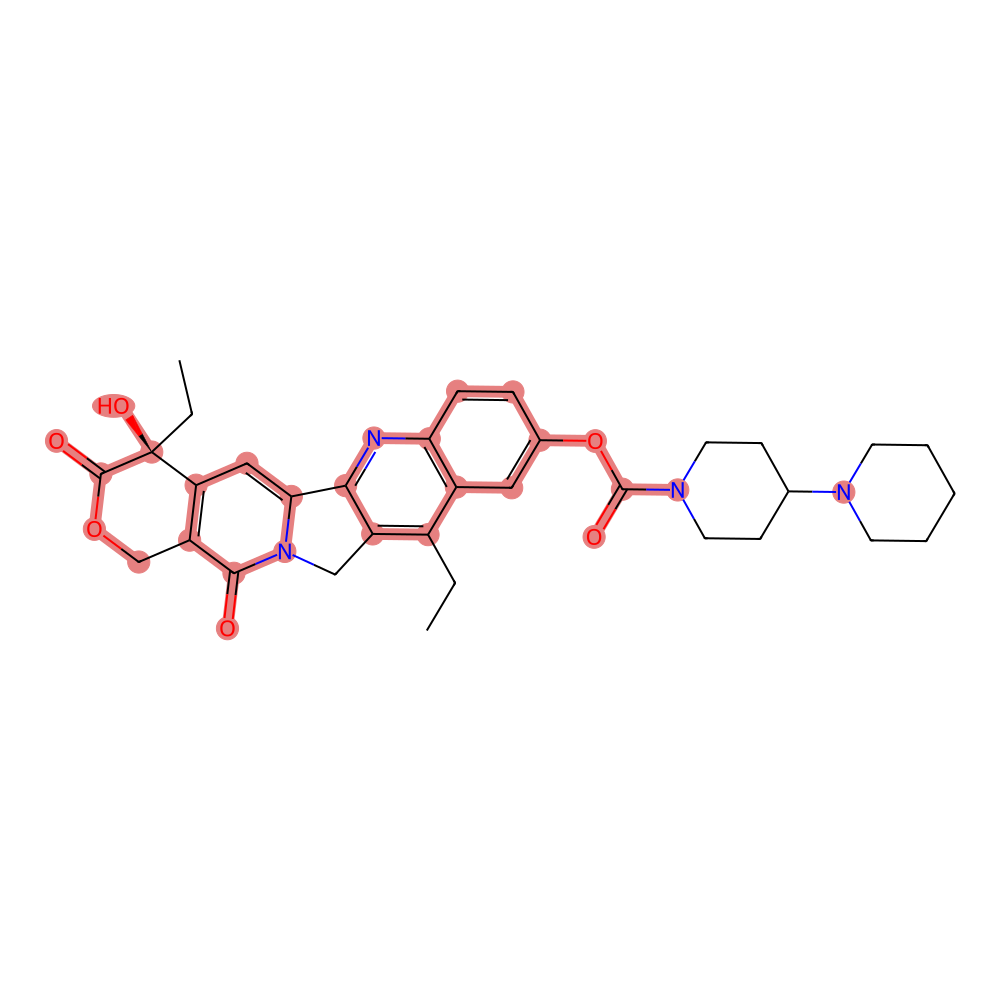

Chemical groups found: ['Tertiary_alcohol', 'Tertiary_aliph_amine', 'Lactone', 'Pyridine_Derivatives', 'Pyridine_Derivatives', 'Lactam', 'Urethan', 'Oxoarene', 'Hetero_N_basic_no_H', 'Hetero_N_nonbasic', 'Heterocyclic', 'Heterocyclic', 'Naphtalene_Derivative']
Rings found: {'non fused aromatic rings': {'6 membered ring': 2}, 'non fused non aromatic rings': {'6 membered ring': 2}, 'fused aromatic rings': {'6 membered ring': 1}, 'fused non aromatic rings': {'5 membered ring': 1, '6 membered ring': 1}, 'fused mixed rings': {'5 membered ring': 1, '6 membered ring': 1}}


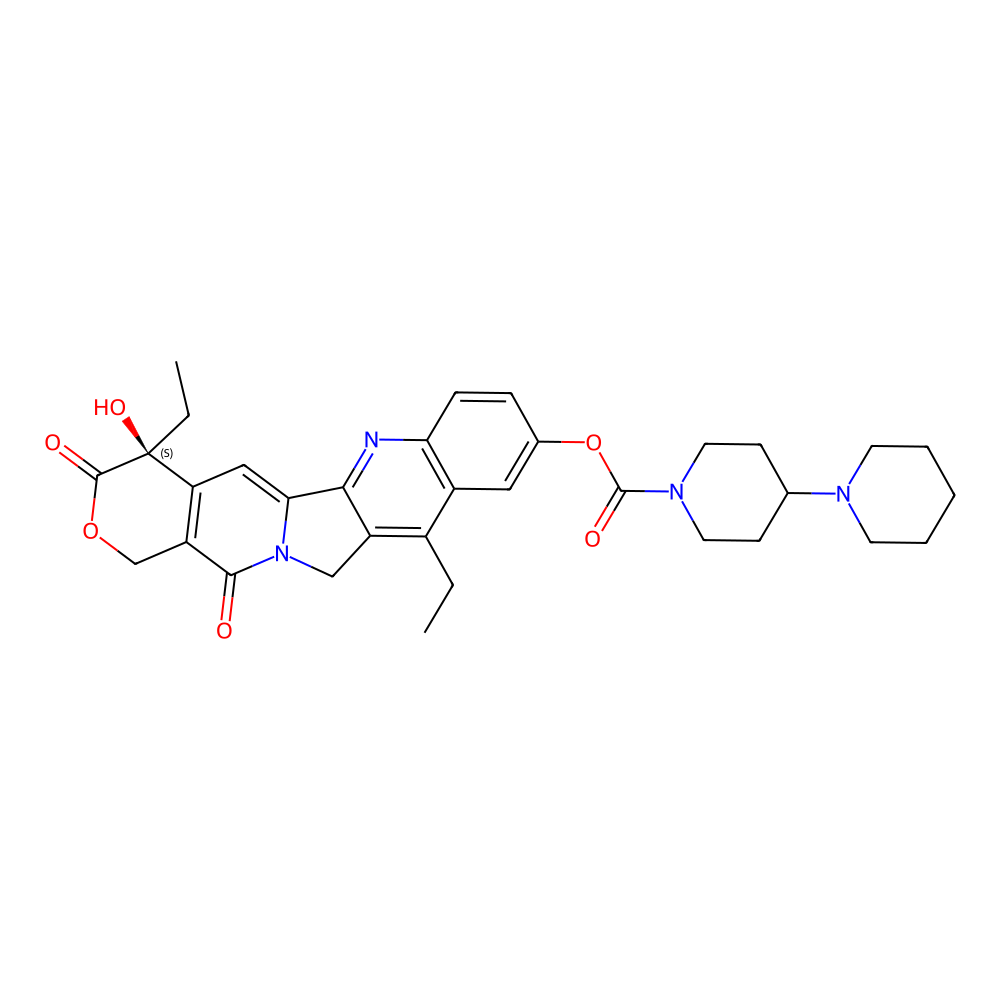

In [24]:
# Example SMILES string to highlight
smiles_string = 'CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)[C@@]4(CC)O)C2=NC5=C1C=C(C=C5)OC(=O)N6CCC(CC6)N7CCCCC7'

# Highlight the chemical groups in the molecule
highlight_chemical_groups(smiles_string, smarts_patterns)


# Find chemical groups
chemical_groups_found = find_smiles_patterns(smiles_string)
print("Chemical groups found:", chemical_groups_found)

# Find rings
results = find_rings(smiles_string)
non_empty_results = {category: rings for category, rings in results.items() if rings}
if non_empty_results:
    print(f"Rings found: {non_empty_results}")

m = Chem.MolFromSmiles(smiles_string)
m